In [13]:
import numpy as np
import pandas as pd
import os
import time
%matplotlib inline
import matplotlib.pyplot as mp
from PIL import Image
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

In [14]:
dataDir = 'resized'

# Hyperparameters
batch_size = 300
split = 0.1
epochs = 30
lr = 0.001


In [15]:
image_files = [f for f in glob.glob(r'resized' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.seed(42)
random.shuffle(image_files)

img_dims = (64,64,3)
num_classes = 6

data = []
labels = []

# converting images to arrays and labelling the categories
for img in image_files:

    image = cv2.imread(img)
    
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
        
    data.append(image)

    label = img.split(os.path.sep)[-2] # C:\Files\gender_dataset_face\woman\face_1162.jpg
    if label == "AbdomenCT":
        label = 0
    elif label == "BreastMRI":
        label = 1
    elif label == 'ChestCT':
        label = 2
    elif label =='CXR':
        label = 3
    elif label == 'Hand':
        label = 4
    elif label == 'HeadCT':
        label = 5
        
    labels.append([label]) # [[1], [0], [0], ...]
print(data[0].shape)


(64, 64, 3)


In [16]:
# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.15,
                                                  random_state=42)

trainY = to_categorical(trainY, num_classes=num_classes) # [[1, 0], [0, 1], [0, 1], ...]
testY = to_categorical(testY, num_classes=num_classes)

In [17]:
# define model
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
        inputShape = (depth, height, width)
        chanDim = 1
    
    # The axis that should be normalized, after a Conv2D layer with data_format="channels_first", 
    # set axis=1 in BatchNormalization.

    model.add(Conv2D(7, (3, 3), padding="same", input_shape=inputShape)),
    model.add(BatchNormalization(axis=chanDim)),
    model.add(Activation("relu")),
    model.add(MaxPooling2D(pool_size=(2, 2))),
    model.add(Dropout(0.25)),

    model.add(Conv2D(14, (2, 2), padding="same")),
    model.add(BatchNormalization(axis=chanDim)),
    model.add(Activation("relu")),
    model.add(MaxPooling2D(pool_size=(2, 2))),
    model.add(Dropout(0.25)),

    model.add(Flatten()),
    model.add(Dense(128)),
    model.add(Activation("relu")),
    model.add(Dense(classes, activation="softmax")),

    return model

# build model
model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2],
                            classes=6)
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 7)         196       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 7)        28        
 ormalization)                                                   
                                                                 
 activation_4 (Activation)   (None, 64, 64, 7)         0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 7)        0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 32, 32, 7)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 14)       

In [18]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
  loss='categorical_crossentropy',
  metrics=['categorical_crossentropy', 'accuracy'])

In [19]:
# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.3,
                         horizontal_flip=True,vertical_flip=True, fill_mode="nearest")

In [20]:
# train the model
H = model.fit(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, verbose=1)

Epoch 1/30


2022-05-06 09:11:50.443381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


167/167 [==============================] - ETA: 0s - loss: 0.3311 - categorical_crossentropy: 0.3311 - accuracy: 0.9090

2022-05-06 09:12:14.621914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


167/167 [==============================] - 26s 148ms/step - loss: 0.3311 - categorical_crossentropy: 0.3311 - accuracy: 0.9090 - val_loss: 1.1512 - val_categorical_crossentropy: 1.1512 - val_accuracy: 0.5845
Epoch 2/30
167/167 [==============================] - 23s 136ms/step - loss: 0.0605 - categorical_crossentropy: 0.0605 - accuracy: 0.9815 - val_loss: 0.3948 - val_categorical_crossentropy: 0.3948 - val_accuracy: 0.8469
Epoch 3/30
167/167 [==============================] - 22s 133ms/step - loss: 0.0458 - categorical_crossentropy: 0.0458 - accuracy: 0.9847 - val_loss: 0.0575 - val_categorical_crossentropy: 0.0575 - val_accuracy: 0.9893
Epoch 4/30
167/167 [==============================] - 22s 133ms/step - loss: 0.0376 - categorical_crossentropy: 0.0376 - accuracy: 0.9877 - val_loss: 0.0300 - val_categorical_crossentropy: 0.0300 - val_accuracy: 0.9923
Epoch 5/30
167/167 [==============================] - 22s 131ms/step - loss: 0.0351 - categorical_crossentropy: 0.0351 - accuracy: 0.98

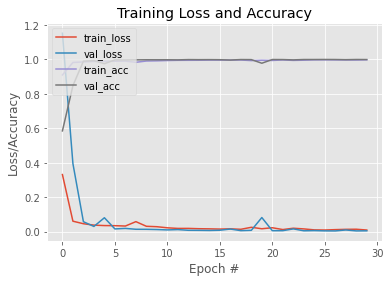

In [21]:
# plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")


plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

# save plot to disk
plt.savefig('plot.png')

In [25]:
import pickle

pickle.dump(model, open('model.pkl', 'wb'))

2022-05-06 09:23:22.828855: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://0f0c6952-6884-4f57-a041-684cb29f4e96/assets


In [23]:
confusion = tf.math.confusion_matrix(testY.argmax(axis=1), model.predict(testX).argmax(axis=1), num_classes=6)

2022-05-06 09:23:05.125537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [24]:
correct = sum(np.diag(confusion))   # Sum over diagonal elements to count correct predictions
print("Correct predictions: ",correct,"of",len(testY))
print("Accuracy: ",correct/len(testY) * 100,"%")
print(confusion)

Correct predictions:  8831 of 8844
Accuracy:  99.85300768882858 %
tf.Tensor(
[[1473    0    0    0    0    0]
 [   0 1327    0    0    0    0]
 [   0    0 1512    0    0    0]
 [   0    0    0 1528    2    1]
 [   0    3    0    3 1492    4]
 [   0    0    0    0    0 1499]], shape=(6, 6), dtype=int32)
